In [1]:
%pip install pyspark
%pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=c547b6e2bcc52bab5d89e540bc89528352c54add0f8651c09341632286d60b57
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [4]:
CaseDetail = spark.read.csv("CaseDetail.csv", header=True, inferSchema=True)
CaseHeader = spark.read.csv("CaseHeader.csv", header=True, inferSchema=True)
MsCaseType = spark.read.csv("MsCaseType.csv", header=True, inferSchema=True)
MsPolice = spark.read.csv("MsPolice.csv", header=True, inferSchema=True)
MsPoliceOffice = spark.read.csv("MsPoliceOffice.csv", header=True, inferSchema=True)
MsVictim = spark.read.csv("MsVictim.csv", header=True, inferSchema=True)

CaseDetail.registerTempTable("CaseDetail")
CaseHeader.registerTempTable("CaseHeader")
MsCaseType.registerTempTable("MsCaseType")
MsPolice.registerTempTable("MsPolice")
MsPoliceOffice.registerTempTable("MsPoliceOffice")
MsVictim.registerTempTable("MsVictim")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+----+------------------+
|Case|PoliceOfficeRegion|
+----+------------------+
|  30|        California|
|  28|           Florida|
|  28|           Arizona|
|  28|          Nebraska|
|  23|            Oregon|
+----+------------------+



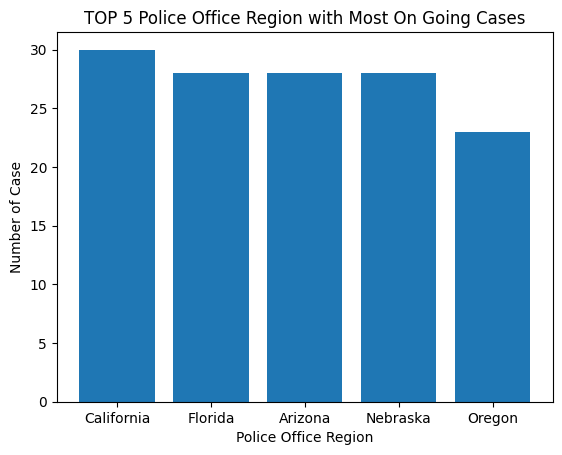

In [9]:
office = spark.sql("""
  SELECT COUNT(CaseStatus) AS Case, PoliceOfficeRegion FROM MsPoliceOffice AS mpo
  JOIN MsPolice AS mp ON mpo.PoliceOfficeID = mp.PoliceOfficeID
  JOIN CaseDetail AS cd ON mp.PoliceID = cd.PoliceID
  JOIN CaseHeader AS ch ON ch.CaseID = cd.CaseID
  WHERE ch.CaseStatus LIKE "On Going"
  GROUP BY PoliceOfficeRegion
  ORDER BY COUNT(CaseStatus) DESC
  LIMIT 5
""")

office.show()
office = office.toPandas()

plt.bar(office["PoliceOfficeRegion"], office["Case"])
plt.xlabel("Police Office Region")
plt.ylabel("Number of Case")
plt.title("TOP 5 Police Office Region with Most On Going Cases")
plt.show()

+---+
|  A|
+---+
| 48|
| 41|
| 68|
| 52|
+---+



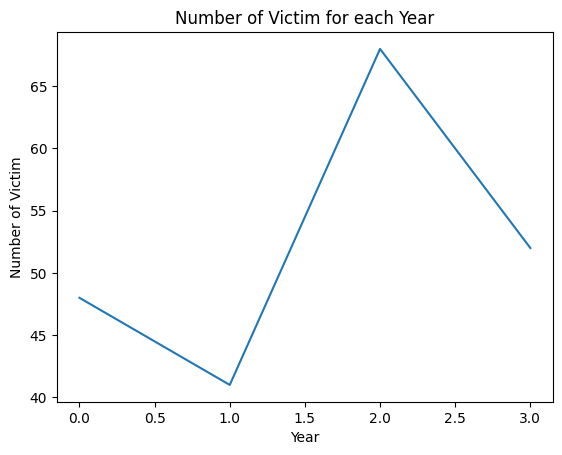

In [10]:
victim = spark.sql("""
  SELECT COUNT(mv.CaseID) AS A FROM MsVictim AS mv JOIN CaseHeader AS ch ON mv.CaseID = ch.CaseID
  Join CaseDetail AS cd ON ch.CaseID = cd.CaseID
  JOIN MsPolice AS mp ON mp.PoliceID = cd.PoliceID
  JOIN MsPoliceOffice AS mpo ON mpo.PoliceOfficeID = mp.PoliceOfficeID

  WHERE PoliceOfficeRegion LIKE "NEVADA" OR PoliceOfficeRegion LIKE "Washington" OR PoliceOfficeRegion LIKE "Oregon" OR PoliceOfficeRegion LIKE "California"
  GROUP BY YEAR(CaseDate)
  ORDER BY YEAR(CaseDate)
""")

victim.show()
victim = victim.toPandas()

plt.plot(victim["A"])
plt.xlabel("Year")
plt.ylabel("Number of Victim")
plt.title("Number of Victim for each Year")
plt.show()

+------------+---+
|CaseTypeName|  A|
+------------+---+
|Misdemeanors| 98|
|   Violation|133|
|    Felonies|226|
+------------+---+



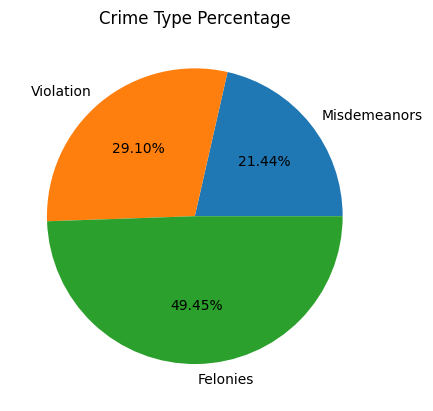

In [11]:
crime = spark.sql("""
  SELECT (
    CASE
      WHEN CaseTypeName IN ("Robbery", "Drug", "Burglary") THEN 'Violation'
      WHEN CaseTypeName IN ("Murder", "Cybercrime", "Terrorism", "Foreign Counterintelligence") THEN 'Felonies'
      WHEN CaseTypeName IN ("Fraud and Scam", "Family Violance", "White-Colar Crime") THEN 'Misdemeanors'
    END
  ) AS CaseTypeName, COUNT(mv.VictimID) AS A
  FROM MsVictim as mv JOIN CaseHeader as ch ON mv.CaseID = ch.CaseID
  JOIN MsCaseType as mct ON mct.CaseTypeID = ch.CaseTypeID
  GROUP BY(
    CASE
      WHEN mct.CaseTypeName IN ('Robbery', 'Drug', 'Burglary') THEN 'Violation'
      WHEN mct.CaseTypeName IN ('Murder', 'Cybercrime', 'Terrorism', 'Foreign Counterintelligence') THEN 'Felonies'
      WHEN CaseTypeName IN ("Fraud and Scam", "Family Violance", "White-Colar Crime") THEN 'Misdemeanors'
    END
  )
  HAVING COUNT(ch.CaseID) > 50
""")

crime.show()
crime = crime.toPandas()

plt.title("Crime Type Percentage")
plt.pie(crime["A"], labels = crime["CaseTypeName"], autopct="%.2f%%")
plt.show()